🌡️ Extreme Temperatures
=======================

Paris → 75  
Lyon → 69  
Bordeaux → 33  
Marseille → 13  

We deliberately use daily data rather than hourly data because daily extremes are the standard basis 
for climate and public-health heat indicators, while hourly data would substantially increase 
complexity without improving robustness or interpretability for this project. Daily temperature profiles 
could be used once heatwaves are IDed.  

Note:
Raw data files are not tracked in Git.
Paths assume data is stored locally in ../data/.


#### Import libraries

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

output_dir = "../figures/1_fig"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

import matplotlib
_orig_show = matplotlib.backend_bases.FigureManagerBase.show
_counter = [1]

def patched_show(*args, **kwargs):
    fig = plt.gcf() # Get current figure
    filepath = os.path.join(output_dir, f"plot_{_counter[0]}.png")
    fig.savefig(filepath, bbox_inches='tight', dpi=300)
    print(f"Saved: {filepath}")
    _counter[0] += 1
    
plt.show = patched_show
sns.utils.plt.show = patched_show

#### Functions

In [2]:
# define path for raw data
def load_city_data(path):
    """
    Load a Meteo-France CSV file and parse the date column.
    """
    df = pd.read_csv(path, sep=";")
    df.columns = df.columns.astype(str).str.strip()
    df["date"] = pd.to_datetime(df["AAAAMMJJ"], format="%Y%m%d", errors="coerce")
    df = df.dropna(subset=["date"])
    df = df.drop('AAAAMMJJ', axis=1) # delete as AAAAMMJJ == date
    return df

# Select the top 5 meteo stations per city
def select_top_stations(df, min_tx_days=8000, min_end_year=2015, n_stations=5):
    """
    Select the best weather stations based on:
    - number of available TX (daily max temperature) values
    - recent data availability
    """
    summary = (
        df.groupby(["NUM_POSTE", "NOM_USUEL"])
          .agg(
              n_TX=("TX", "count"),
              start_date=("date", "min"),
              end_date=("date", "max")
          )
          .reset_index()
    )

    selected = (
        summary[
            (summary["n_TX"] >= min_tx_days) &
            (summary["end_date"].dt.year >= min_end_year)
        ]
        .sort_values("n_TX", ascending=False)
        .head(n_stations)
    )

    return selected


# Filter results by city/stations
def filter_city_by_stations(df, stations_df):
    """
    Keep only observations from the selected stations.
    """
    station_ids = stations_df["NUM_POSTE"].tolist()
    return df[df["NUM_POSTE"].isin(station_ids)].copy()


#### Load the data
| Variable | Description |
|--------|------------|
| NUM_POSTE | Station ID |
| NOM_USUEL | Station name |
| LAT | Latitude |
| LON | Longitude |
| ALTI | Altitude (m) |
| AAAAMMJJ | Date (YYYYMMDD) |
| date | Parsed date |
| RR | Daily precipitation (mm) |
| QRR | Quality flag (RR) |
| TN | Daily minimum temperature (°C) |
| QTN | Quality flag (TN) |
| HTN | Time of TN |
| TX | Daily maximum temperature (°C) |
| QTX | Quality flag (TX) |
| HTX | Time of TX |
| TM | Mean daily temperature (°C) |
| QTM | Quality flag (TM) |
| TNTXM | (TN + TX) / 2 |
| TAMPLI | Daily thermal amplitude (TX − TN) |
| TNSOL | Min ground temperature (10 cm) |
| TN50 | Min temperature at 50 cm |
| DG | Frost duration (minutes) |
| FFM | Mean daily wind speed (10 m) |
| FF2M | Mean wind speed (2 m) |
| FXY | Max hourly wind (10 m) |
| DXY | Direction of max wind |
| HXY | Time of max wind |
| FXI | Max instantaneous wind (10 m) |
| DXI | Direction of FXI |
| HXI | Time of FXI |
| FXI2 | Max instantaneous wind (2 m) |
| FXI3S | Max 3-second wind gust |
| DRR | Duration of precipitation (min) |
| Q* | Quality flag for variable `*` |


In [3]:
# =========================
# Base path to data folder
# =========================
DATA_DIR = "../data/0_initial"

# =========================
# File paths
# =========================
PATH_75 = f"{DATA_DIR}/Paris_Q_75_previous-1950-2024_RR-T-Vent.zip"
PATH_13 = f"{DATA_DIR}/Marseille_Q_13_previous-1950-2024_RR-T-Vent.zip"
PATH_33 = f"{DATA_DIR}/Bordeaux_Q_33_previous-1950-2024_RR-T-Vent.zip"
PATH_69 = f"{DATA_DIR}/Lyon_Q_69_previous-1950-2024_RR-T-Vent.zip"

# =========================
# Load data
# =========================
df_75 = load_city_data(PATH_75)
df_13 = load_city_data(PATH_13)
df_33 = load_city_data(PATH_33)
df_69 = load_city_data(PATH_69)

# =========================
# Preview data
# =========================
print('Paris')
display(df_75.head())
display(df_75.columns)
print('Marseille')
display(df_13.head())
display(df_13.columns)
print('Bordeaux')
display(df_33.head())
display(df_33.columns)
print('Lyon')
display(df_69.head())
display(df_69.columns)

Paris


,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,RR,QRR,TN,QTN,HTN,...,QHXI2,FXI3S,QFXI3S,DXI3S,QDXI3S,HXI3S,QHXI3S,DRR,QDRR,date
0,75101001,INNOCENTS,48.860667,2.348333,37,0.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-01-01
1,75101001,INNOCENTS,48.860667,2.348333,37,1.8,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-01-02
2,75101001,INNOCENTS,48.860667,2.348333,37,2.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-01-03
3,75101001,INNOCENTS,48.860667,2.348333,37,0.2,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-01-04
4,75101001,INNOCENTS,48.860667,2.348333,37,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950-01-05


Index(['NUM_POSTE', 'NOM_USUEL', 'LAT', 'LON', 'ALTI', 'RR', 'QRR', 'TN',
       'QTN', 'HTN', 'QHTN', 'TX', 'QTX', 'HTX', 'QHTX', 'TM', 'QTM', 'TNTXM',
       'QTNTXM', 'TAMPLI', 'QTAMPLI', 'TNSOL', 'QTNSOL', 'TN50', 'QTN50', 'DG',
       'QDG', 'FFM', 'QFFM', 'FF2M', 'QFF2M', 'FXY', 'QFXY', 'DXY', 'QDXY',
       'HXY', 'QHXY', 'FXI', 'QFXI', 'DXI', 'QDXI', 'HXI', 'QHXI', 'FXI2',
       'QFXI2', 'DXI2', 'QDXI2', 'HXI2', 'QHXI2', 'FXI3S', 'QFXI3S', 'DXI3S',
       'QDXI3S', 'HXI3S', 'QHXI3S', 'DRR', 'QDRR', 'date'],
      dtype='object')

Marseille


,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,RR,QRR,TN,QTN,HTN,...,QHXI2,FXI3S,QFXI3S,DXI3S,QDXI3S,HXI3S,QHXI3S,DRR,QDRR,date
0,13001002,AIX-PUYRICARD,43.593333,5.413333,314,0.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1962-07-01
1,13001002,AIX-PUYRICARD,43.593333,5.413333,314,0.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1962-07-02
2,13001002,AIX-PUYRICARD,43.593333,5.413333,314,0.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1962-07-03
3,13001002,AIX-PUYRICARD,43.593333,5.413333,314,0.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1962-07-04
4,13001002,AIX-PUYRICARD,43.593333,5.413333,314,0.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1962-07-05


Index(['NUM_POSTE', 'NOM_USUEL', 'LAT', 'LON', 'ALTI', 'RR', 'QRR', 'TN',
       'QTN', 'HTN', 'QHTN', 'TX', 'QTX', 'HTX', 'QHTX', 'TM', 'QTM', 'TNTXM',
       'QTNTXM', 'TAMPLI', 'QTAMPLI', 'TNSOL', 'QTNSOL', 'TN50', 'QTN50', 'DG',
       'QDG', 'FFM', 'QFFM', 'FF2M', 'QFF2M', 'FXY', 'QFXY', 'DXY', 'QDXY',
       'HXY', 'QHXY', 'FXI', 'QFXI', 'DXI', 'QDXI', 'HXI', 'QHXI', 'FXI2',
       'QFXI2', 'DXI2', 'QDXI2', 'HXI2', 'QHXI2', 'FXI3S', 'QFXI3S', 'DXI3S',
       'QDXI3S', 'HXI3S', 'QHXI3S', 'DRR', 'QDRR', 'date'],
      dtype='object')

Bordeaux


,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,RR,QRR,TN,QTN,HTN,...,QHXI2,FXI3S,QFXI3S,DXI3S,QDXI3S,HXI3S,QHXI3S,DRR,QDRR,date
0,33004001,AMBES,45.041667,-0.608333,5,0.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1957-12-15
1,33004001,AMBES,45.041667,-0.608333,5,0.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1957-12-16
2,33004001,AMBES,45.041667,-0.608333,5,0.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1957-12-17
3,33004001,AMBES,45.041667,-0.608333,5,21.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1957-12-18
4,33004001,AMBES,45.041667,-0.608333,5,0.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1957-12-19


Index(['NUM_POSTE', 'NOM_USUEL', 'LAT', 'LON', 'ALTI', 'RR', 'QRR', 'TN',
       'QTN', 'HTN', 'QHTN', 'TX', 'QTX', 'HTX', 'QHTX', 'TM', 'QTM', 'TNTXM',
       'QTNTXM', 'TAMPLI', 'QTAMPLI', 'TNSOL', 'QTNSOL', 'TN50', 'QTN50', 'DG',
       'QDG', 'FFM', 'QFFM', 'FF2M', 'QFF2M', 'FXY', 'QFXY', 'DXY', 'QDXY',
       'HXY', 'QHXY', 'FXI', 'QFXI', 'DXI', 'QDXI', 'HXI', 'QHXI', 'FXI2',
       'QFXI2', 'DXI2', 'QDXI2', 'HXI2', 'QHXI2', 'FXI3S', 'QFXI3S', 'DXI3S',
       'QDXI3S', 'HXI3S', 'QHXI3S', 'DRR', 'QDRR', 'date'],
      dtype='object')

Lyon


,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,RR,QRR,TN,QTN,HTN,...,QHXI2,FXI3S,QFXI3S,DXI3S,QDXI3S,HXI3S,QHXI3S,DRR,QDRR,date
0,69006001,AMPLEPUIS BOURG,45.971667,4.331667,435,0.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1963-03-01
1,69006001,AMPLEPUIS BOURG,45.971667,4.331667,435,0.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1963-03-02
2,69006001,AMPLEPUIS BOURG,45.971667,4.331667,435,0.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1963-03-03
3,69006001,AMPLEPUIS BOURG,45.971667,4.331667,435,0.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1963-03-04
4,69006001,AMPLEPUIS BOURG,45.971667,4.331667,435,0.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1963-03-05


Index(['NUM_POSTE', 'NOM_USUEL', 'LAT', 'LON', 'ALTI', 'RR', 'QRR', 'TN',
       'QTN', 'HTN', 'QHTN', 'TX', 'QTX', 'HTX', 'QHTX', 'TM', 'QTM', 'TNTXM',
       'QTNTXM', 'TAMPLI', 'QTAMPLI', 'TNSOL', 'QTNSOL', 'TN50', 'QTN50', 'DG',
       'QDG', 'FFM', 'QFFM', 'FF2M', 'QFF2M', 'FXY', 'QFXY', 'DXY', 'QDXY',
       'HXY', 'QHXY', 'FXI', 'QFXI', 'DXI', 'QDXI', 'HXI', 'QHXI', 'FXI2',
       'QFXI2', 'DXI2', 'QDXI2', 'HXI2', 'QHXI2', 'FXI3S', 'QFXI3S', 'DXI3S',
       'QDXI3S', 'HXI3S', 'QHXI3S', 'DRR', 'QDRR', 'date'],
      dtype='object')

#### Select stations (same logic for all cities)

In [4]:
stations_75 = select_top_stations(df_75)
stations_13 = select_top_stations(df_13)
stations_33 = select_top_stations(df_33)
stations_69 = select_top_stations(df_69)

#### Keep the top 5 stations per city

In [5]:
df_75 = filter_city_by_stations(df_75, stations_75)
df_13 = filter_city_by_stations(df_13, stations_13)
df_33 = filter_city_by_stations(df_33, stations_33)
df_69 = filter_city_by_stations(df_69, stations_69)

#### Examine the stations selected

In [6]:
print("Paris stations:")
print(stations_75[["NUM_POSTE", "NOM_USUEL", "n_TX"]])
print('\n')
print("Lyon stations:")
print(stations_69[["NUM_POSTE", "NOM_USUEL", "n_TX"]])
print('\n')
print("Bordeaux stations:")
print(stations_33[["NUM_POSTE", "NOM_USUEL", "n_TX"]])
print('\n')
print("Marseille stations:")
print(stations_13[["NUM_POSTE", "NOM_USUEL", "n_TX"]])


Paris stations:
    NUM_POSTE         NOM_USUEL   n_TX
16   75114001  PARIS-MONTSOURIS  27394
3    75106001        LUXEMBOURG  17014
23   75116002         BAGATELLE   9608
6    75107005       TOUR EIFFEL   9577
15   75113002       SALPETRIERE   9556


Lyon stations:
    NUM_POSTE       NOM_USUEL   n_TX
10   69029001       LYON-BRON  27394
75   69204002  ST-GENIS-LAVAL  27328
56   69141001         MORNANT  27021
53   69135001         MONSOLS  26874
99   69264001    VILLEFRANCHE  24827


Bordeaux stations:
     NUM_POSTE                NOM_USUEL   n_TX
75    33236002               CAP-FERRET  27394
81    33281001        BORDEAUX-MERIGNAC  27394
143   33529001                   CAZAUX  27394
131   33504001                SAUTERNES  27393
153   33550001  VILLENAVE D'ORNON-INRAE  27363


Marseille stations:
     NUM_POSTE          NOM_USUEL   n_TX
44    13047001             ISTRES  27394
51    13054001          MARIGNANE  27394
108   13103001  SALON DE PROVENCE  27394
2     13001009    AIX 

#### 👀 Visualize Tx (Max temp: weather) and averaged tempartures (climate change)

Saved: ../figures/1_fig/plot_1.png
Saved: ../figures/1_fig/plot_2.png
Saved: ../figures/1_fig/plot_3.png
Saved: ../figures/1_fig/plot_4.png
Saved: ../figures/1_fig/plot_5.png
Saved: ../figures/1_fig/plot_6.png
Saved: ../figures/1_fig/plot_7.png
Saved: ../figures/1_fig/plot_8.png


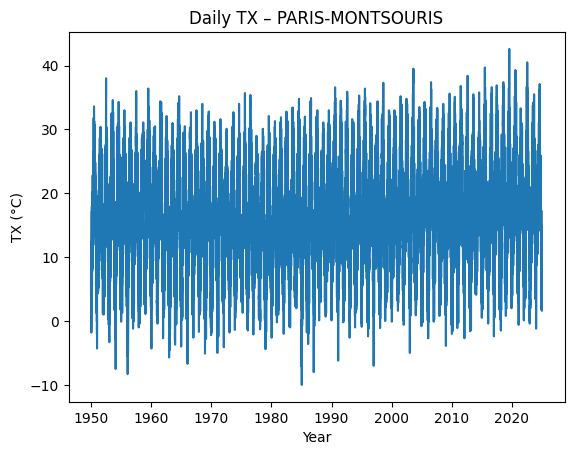

<Figure size 1200x400 with 0 Axes>

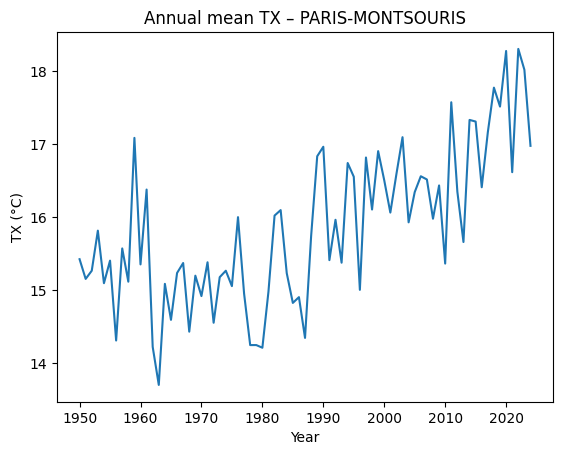

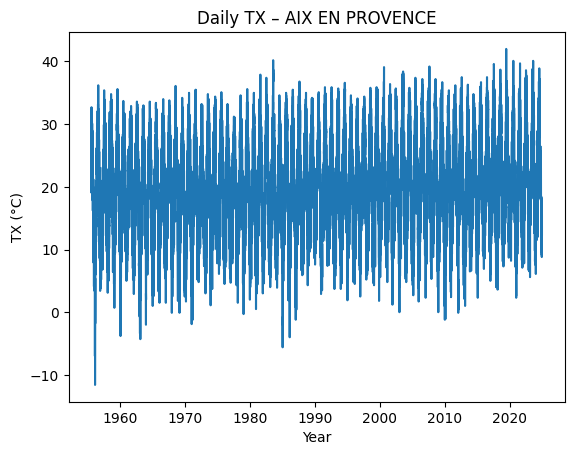

<Figure size 1200x400 with 0 Axes>

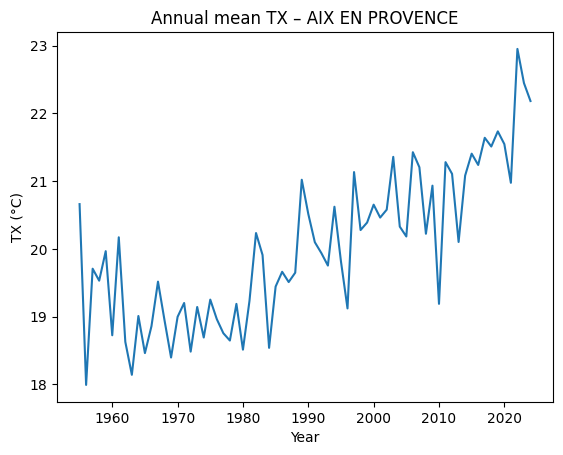

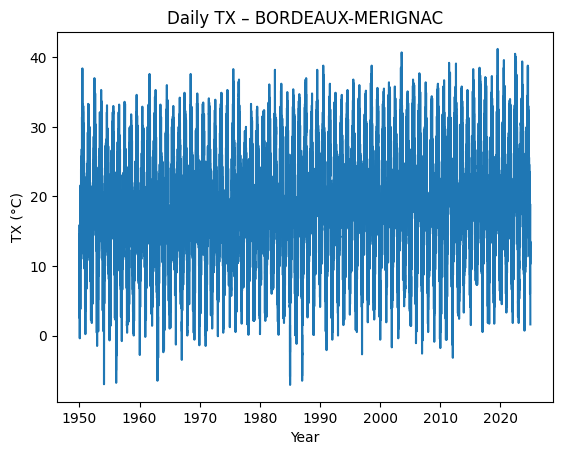

<Figure size 1200x400 with 0 Axes>

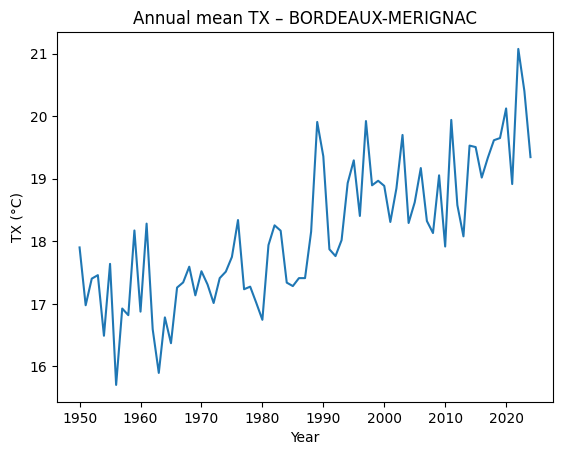

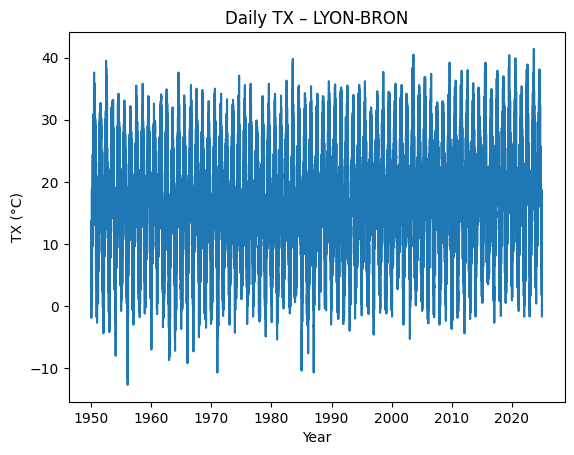

<Figure size 1200x400 with 0 Axes>

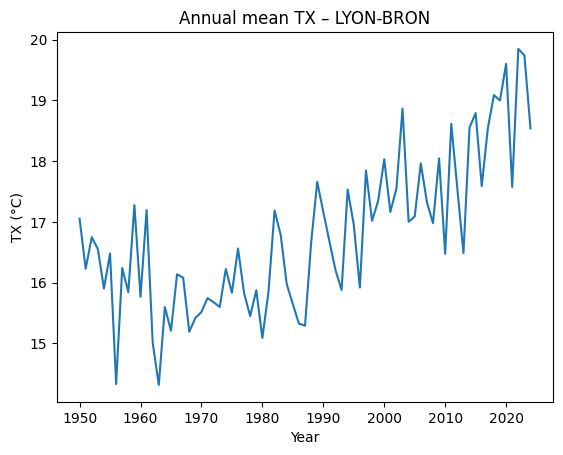

In [7]:
# =========================
# Functions 
# =========================

CITY_OUT_DIR = "../data/1_outputs" # can be used later

def prepare_df(df):
    df = df.copy()
    df["date"] = pd.to_datetime(df["AAAAMMJJ"], format="%Y%m%d")
    return df

def station_quality(df):
    return (
        df.groupby("NOM_USUEL")["TX"]
        .apply(lambda x: x.isna().mean())
        .sort_values()
    )

def plot_daily_tx(df, station):
    d = df[df["NOM_USUEL"] == station]
    plt.figure()
    plt.plot(d["date"], d["TX"])
    plt.title(f"Daily TX – {station}")
    plt.xlabel("Year")
    plt.ylabel("TX (°C)")
    plt.show()

# This operation groups daily TX values by calendar year and 
# computes the arithmetic mean for each year, without applying any running or rolling average.
def plot_annual_tx(df, station):
    d = df[df["NOM_USUEL"] == station].dropna(subset=["TX"])
    d["year"] = d["date"].dt.year
    annual = d.groupby("year")["TX"].mean()

    plt.figure(figsize=(12, 4))
    plt.figure()
    plt.plot(annual.index, annual.values)
    plt.title(f"Annual mean TX – {station}")
    plt.xlabel("Year")
    plt.ylabel("TX (°C)")
    plt.show()

def export_city(df, city_name):
    #CITY_OUT_DIR = "data/1_outputs"
    os.makedirs(CITY_OUT_DIR, exist_ok=True)
    cols = ["date", "NUM_POSTE", "NOM_USUEL", "TX", "TN", "LAT", "LON", "ALTI"]
    df[cols].to_csv(f"{CITY_OUT_DIR}/{city_name}_daily_TX_raw.csv", index=False)

# =========================
# Apply to all cities
# =========================

cities = {
    "Paris": df_75,
    "Marseille": df_13,
    "Bordeaux": df_33,
    "Lyon": df_69
}

for city, df in cities.items():
    # df = prepare_df(df) # this is done already

    tx_missing = station_quality(df)
    best_station = tx_missing.index[0]

    plot_daily_tx(df, best_station)
    plot_annual_tx(df, best_station)

    export_city(df, city)

Paris – Best station: PARIS-MONTSOURIS
Saved: ../figures/1_fig/plot_9.png
Marseille – Best station: AIX EN PROVENCE
Saved: ../figures/1_fig/plot_10.png
Bordeaux – Best station: BORDEAUX-MERIGNAC
Saved: ../figures/1_fig/plot_11.png
Lyon – Best station: LYON-BRON
Saved: ../figures/1_fig/plot_12.png


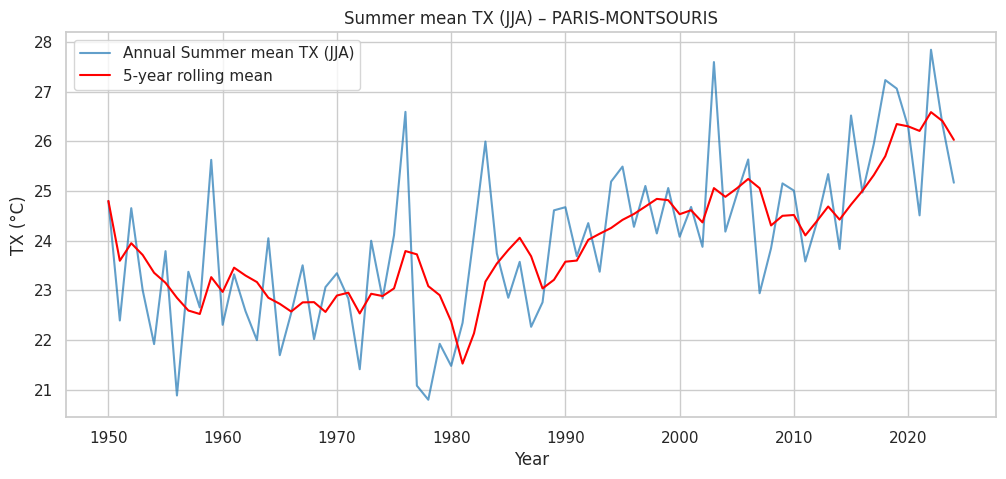

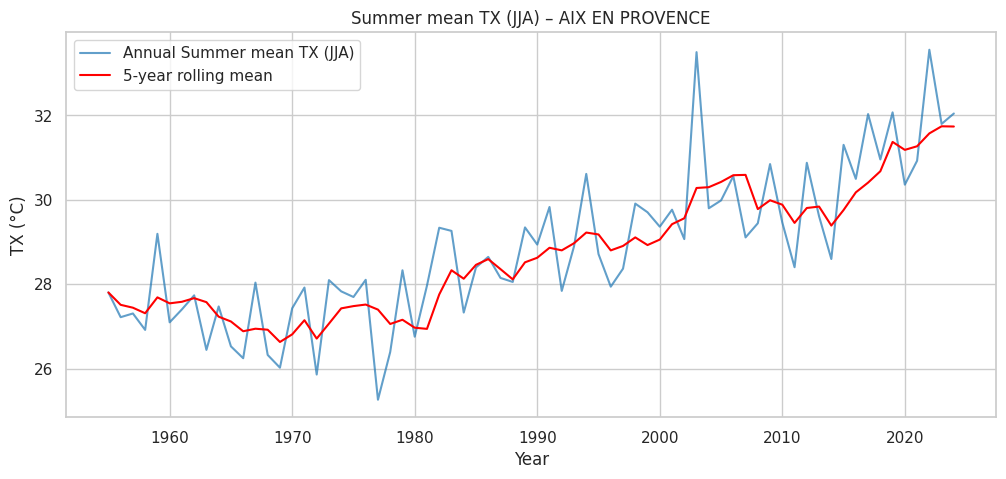

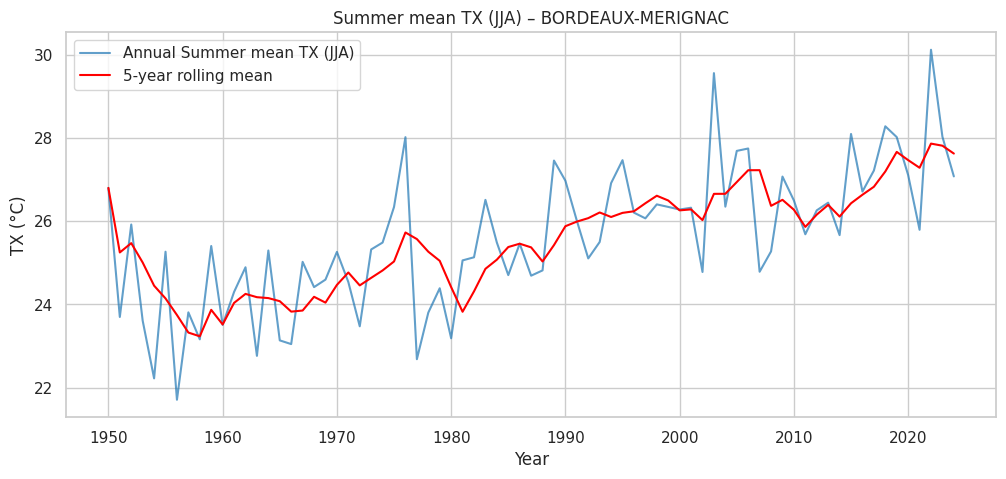

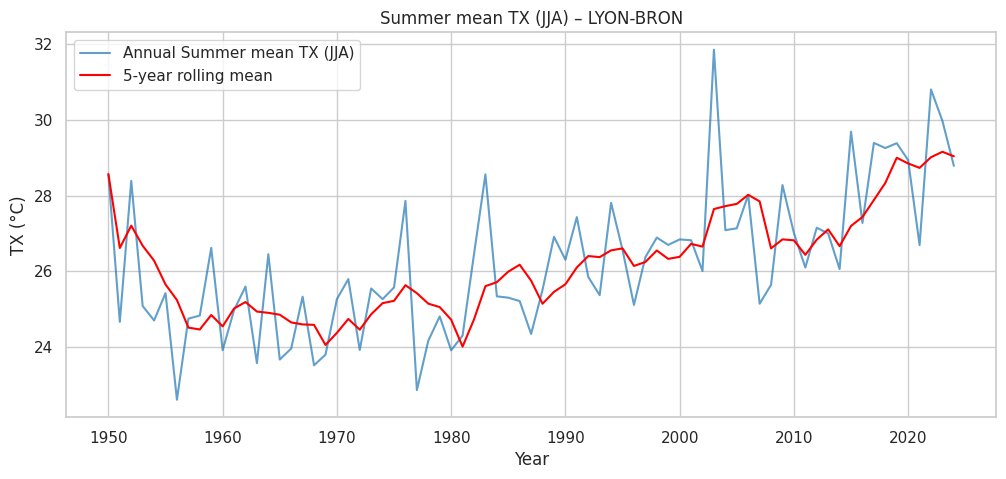

In [8]:
sns.set(style="whitegrid", palette="tab10")
plt.rcParams["figure.figsize"] = (12, 5)

def plot_summer_mean_tx_rolling(df, station, window=5):
    """
    Plots mean TX for summer months (JJA) for a given station as a rolling annual mean.
    - window: size of rolling window in years
    """
    # Filter summer months
    summer_df = df[(df["NOM_USUEL"] == station) & (df["date"].dt.month.isin([6,7,8]))].dropna(subset=["TX"])
    
    # Compute annual summer mean
    summer_mean = summer_df.groupby(summer_df["date"].dt.year)["TX"].mean()
    
    # Compute rolling mean
    summer_mean_roll = summer_mean.rolling(window=window, min_periods=1).mean()
    
    # Plot
    plt.figure()
    sns.lineplot(x=summer_mean.index, y=summer_mean, alpha=0.7, label="Annual Summer mean TX (JJA)")
    sns.lineplot(x=summer_mean_roll.index, y=summer_mean_roll, color="red", label=f"{window}-year rolling mean")
    
    plt.title(f"Summer mean TX (JJA) – {station}")
    plt.xlabel("Year")
    plt.ylabel("TX (°C)")
    plt.legend()
    plt.show()


# =========================
# All cities
# =========================

cities = {
    "Paris": df_75,
    "Marseille": df_13,
    "Bordeaux": df_33,
    "Lyon": df_69
}

# Loop through cities
for city, df in cities.items():
    # Pick the best station (fewest missing TX)
    best_station = df.groupby("NOM_USUEL")["TX"].apply(lambda x: x.isna().mean()).sort_values().index[0]
    
    print(f"{city} – Best station: {best_station}")
    plot_summer_mean_tx_rolling(df, best_station, window=5)

Saved: ../figures/1_fig/plot_13.png


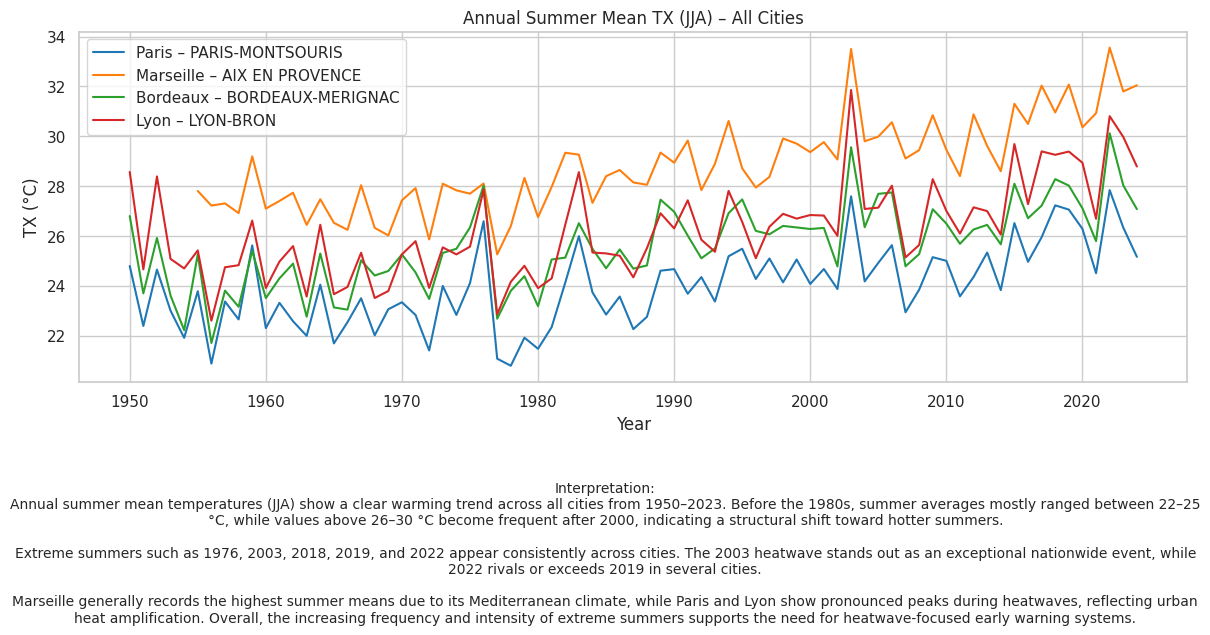

In [9]:
def plot_summer_mean_all_cities(df_dict):
    """
    Plots annual summer mean TX (JJA --> summer months) for all cities
    with an interpretation text below the figure.
    """

    fig, ax = plt.subplots()

    for city, df in df_dict.items():
        # Select best station (fewest missing TX values)
        best_station = (
            df.groupby("NOM_USUEL")["TX"]
            .apply(lambda x: x.isna().mean())
            .sort_values()
            .index[0]
        )

        # Filter summer months (JJA)
        summer_df = df[
            (df["NOM_USUEL"] == best_station) &
            (df["date"].dt.month.isin([6, 7, 8]))
        ].dropna(subset=["TX"])

        # Compute annual summer mean
        summer_mean = summer_df.groupby(
            summer_df["date"].dt.year
        )["TX"].mean()

        # Plot
        sns.lineplot(
            x=summer_mean.index,
            y=summer_mean,
            label=f"{city} – {best_station}",
            ax=ax
        )

    ax.set_title("Annual Summer Mean TX (JJA) – All Cities")
    ax.set_xlabel("Year")
    ax.set_ylabel("TX (°C)")
    ax.legend()

    # Interpretation text below the plot
    interpretation_text = (
        "Interpretation:\n"
        "Annual summer mean temperatures (JJA) show a clear warming trend across all cities from 1950–2023. "
        "Before the 1980s, summer averages mostly ranged between 22–25 °C, while values above 26–30 °C "
        "become frequent after 2000, indicating a structural shift toward hotter summers.\n\n"
        "Extreme summers such as 1976, 2003, 2018, 2019, and 2022 appear consistently across cities. "
        "The 2003 heatwave stands out as an exceptional nationwide event, while 2022 rivals or exceeds "
        "2019 in several cities.\n\n"
        "Marseille generally records the highest summer means due to its Mediterranean climate, "
        "while Paris and Lyon show pronounced peaks during heatwaves, reflecting urban heat amplification. "
        "Overall, the increasing frequency and intensity of extreme summers supports the need for "
        "heatwave-focused early warning systems."
    )

    fig.text(
        0.5, 0.02,
        interpretation_text,
        ha="center",
        va="top",
        fontsize=10,
        wrap=True
    )

    # Make space for the interpretation text
    plt.tight_layout(rect=[0, 0.08, 1, 1])
    plt.show()


# Dictionary of city DataFrames
cities = {
    "Paris": df_75,
    "Marseille": df_13,
    "Bordeaux": df_33,
    "Lyon": df_69
}

plot_summer_mean_all_cities(cities)

PARIS-MONTSOURIS – 27394 days, 0 missing (0.0%)
Saved: ../figures/1_fig/plot_14.png
AIX EN PROVENCE – 25387 days, 0 missing (0.0%)
Saved: ../figures/1_fig/plot_15.png
BORDEAUX-MERIGNAC – 27394 days, 0 missing (0.0%)
Saved: ../figures/1_fig/plot_16.png
LYON-BRON – 27394 days, 0 missing (0.0%)
Saved: ../figures/1_fig/plot_17.png
Saved: ../figures/1_fig/plot_18.png
Saved: ../figures/1_fig/plot_19.png
Saved: ../figures/1_fig/plot_20.png
Saved: ../figures/1_fig/plot_21.png
Saved: ../figures/1_fig/plot_22.png
Saved: ../figures/1_fig/plot_23.png


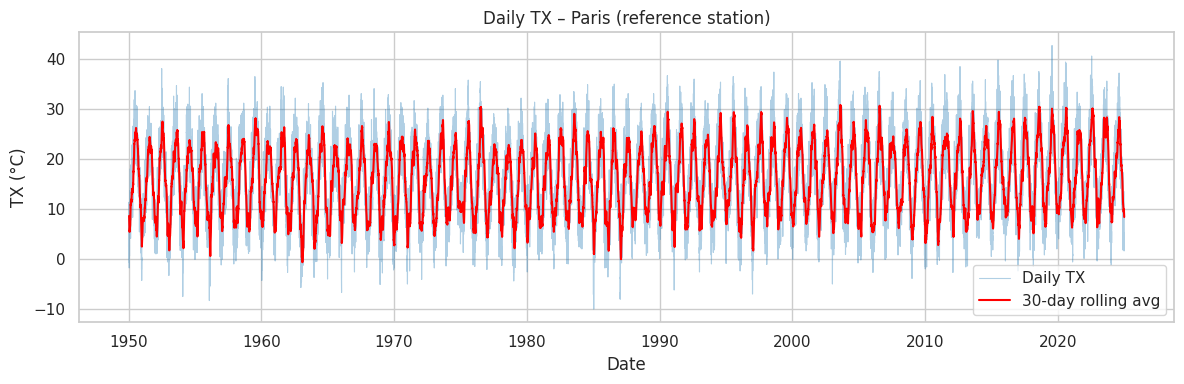

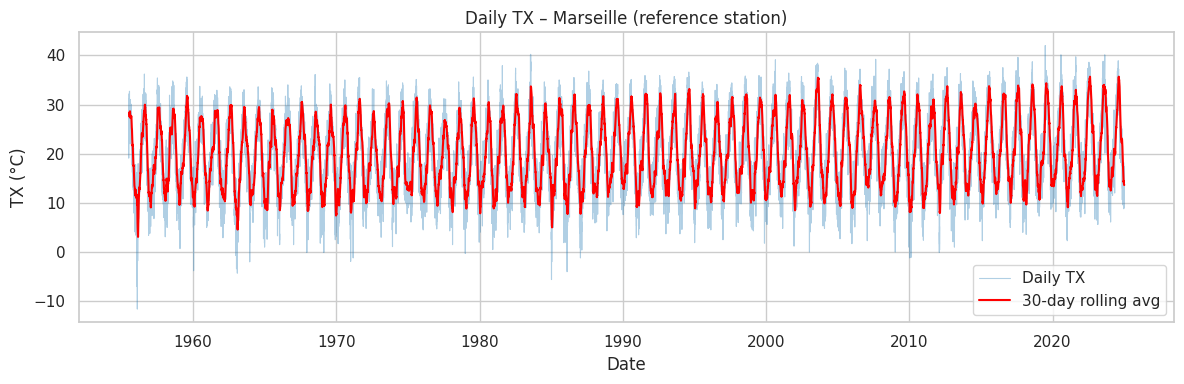

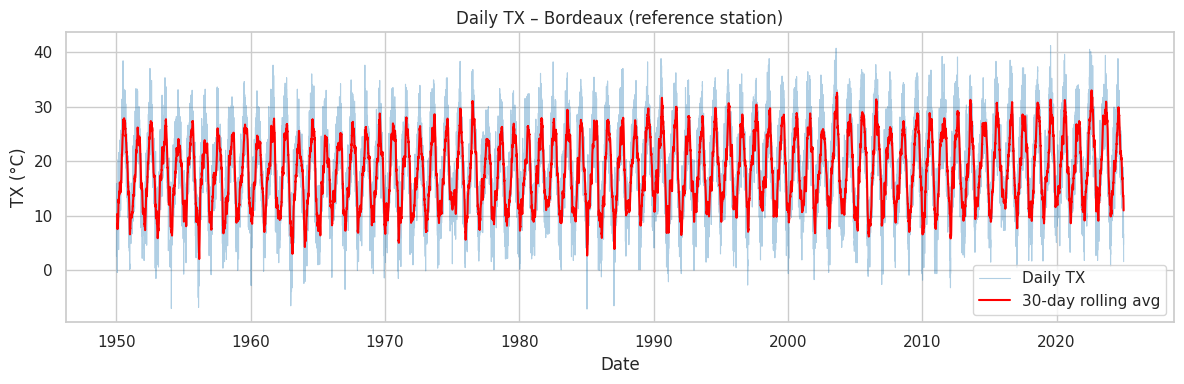

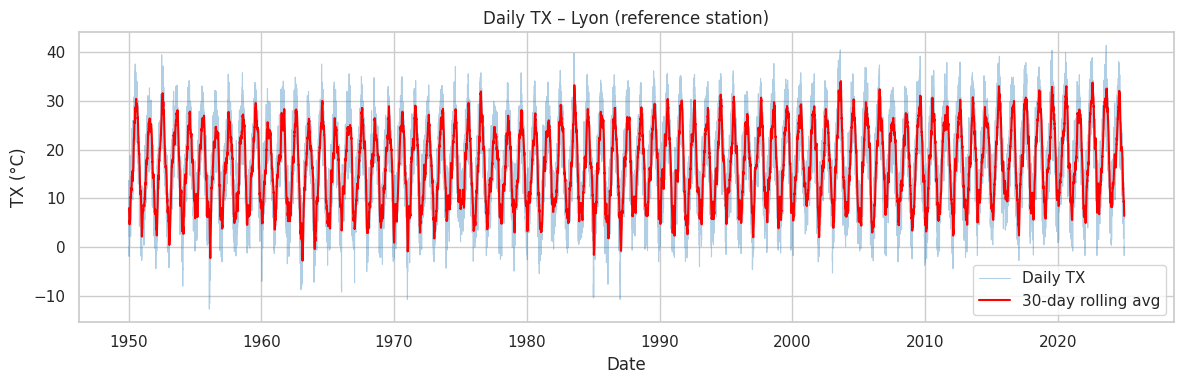

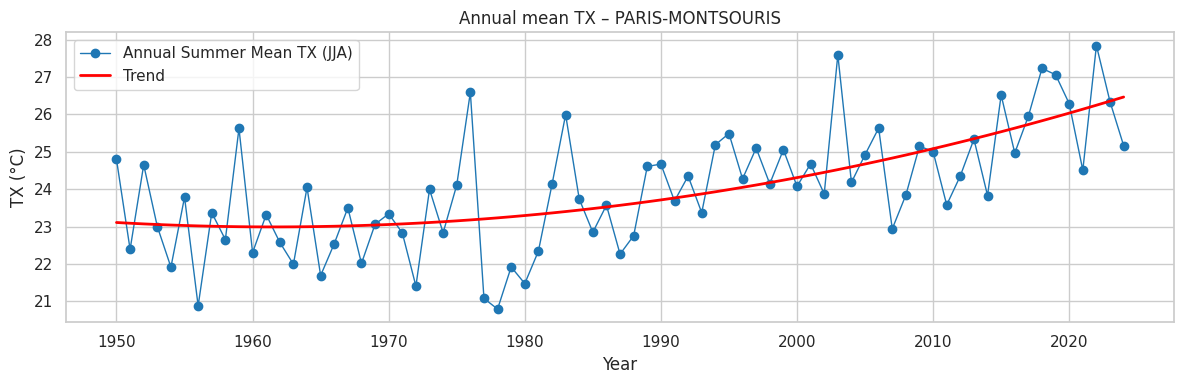

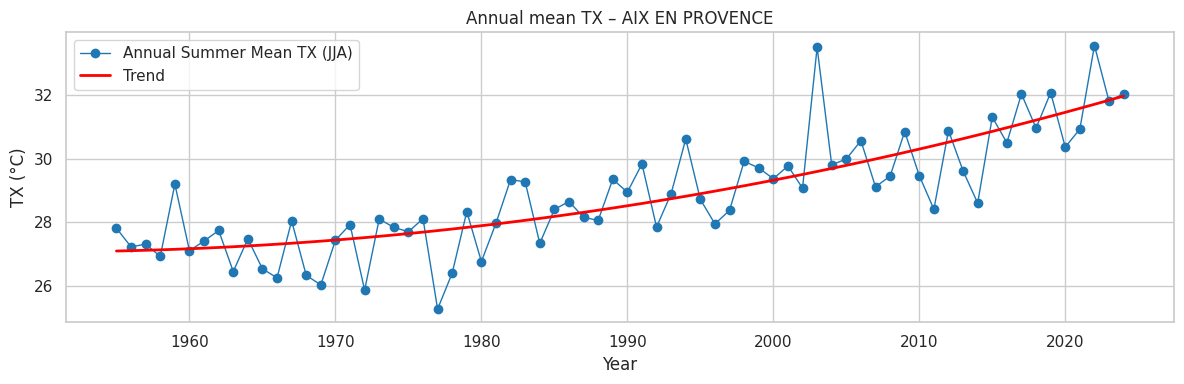

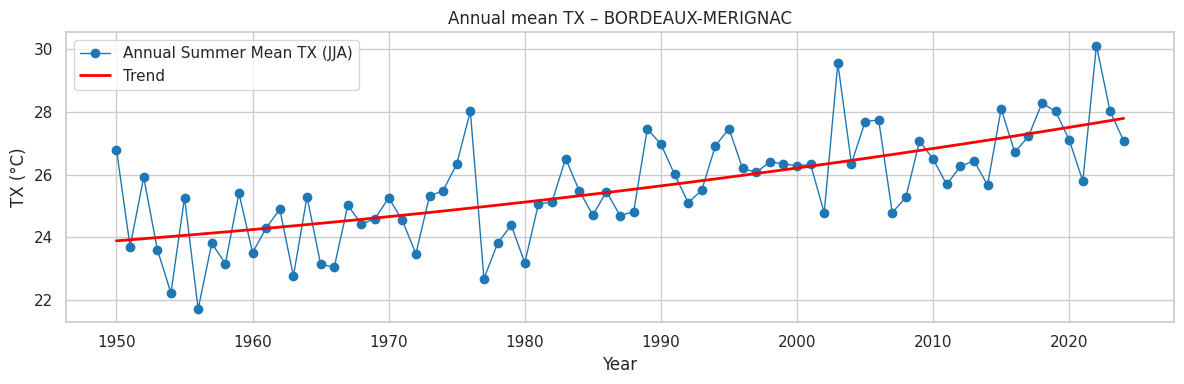

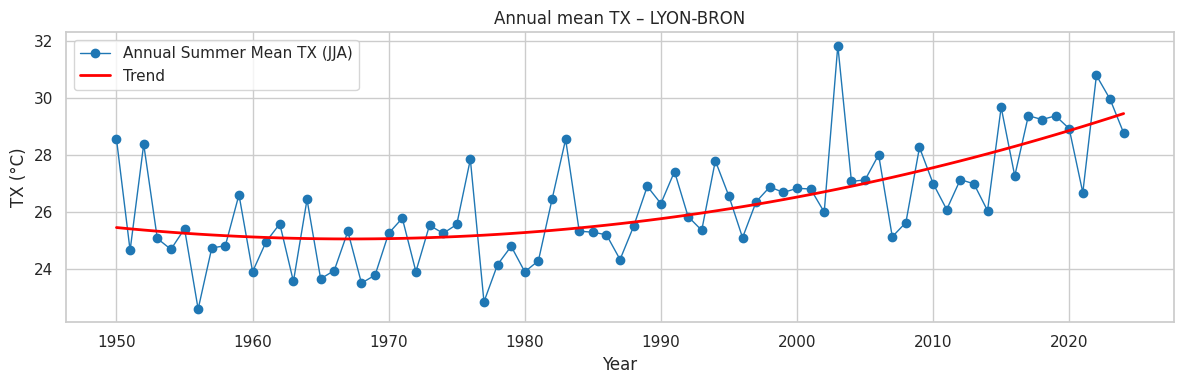

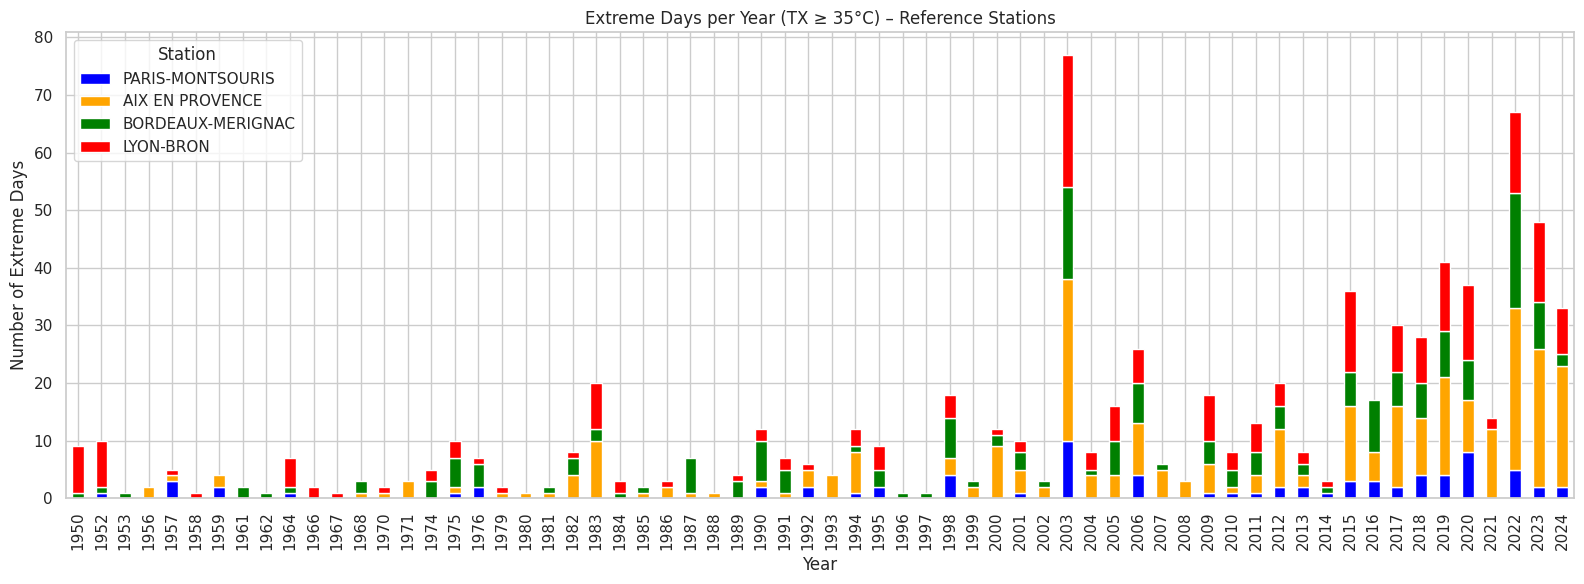

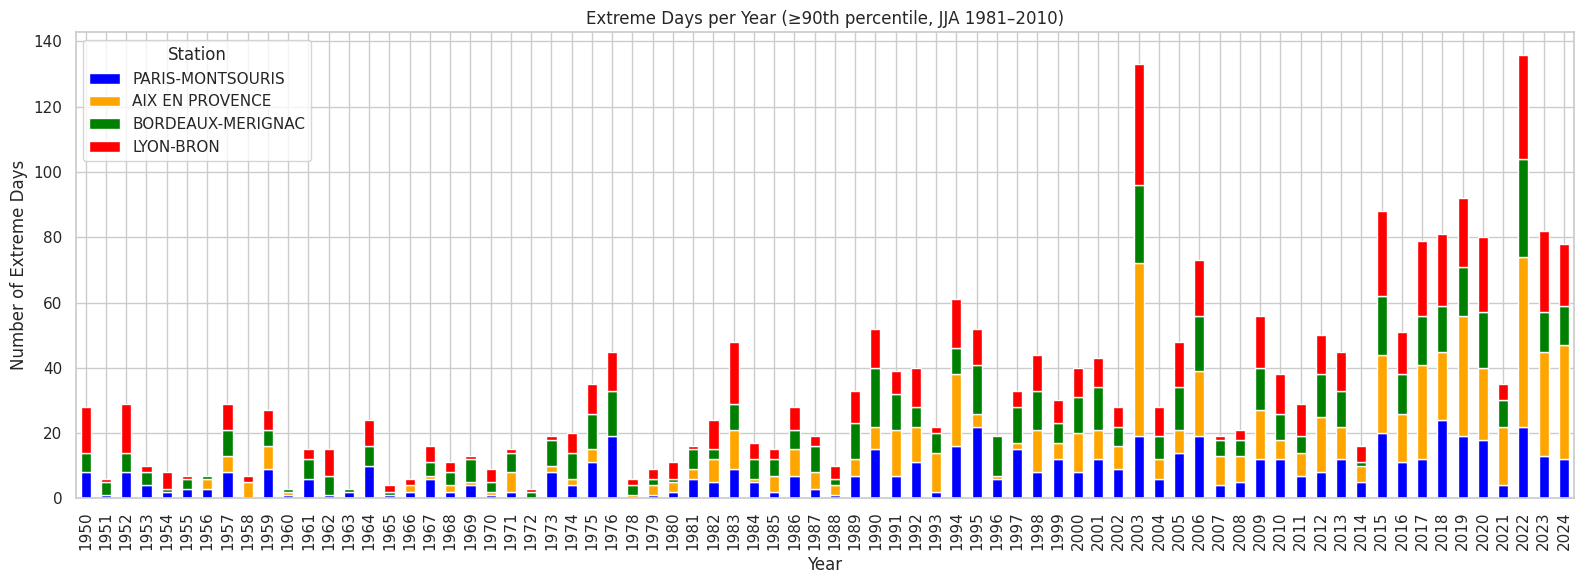

In [10]:
# ============================================================
# 11. Simon’s analysis – TX-only, station-level (FIREWALL)
# ============================================================
#
# This section intentionally RELOADS raw TX data and ignores
# all previous pipeline outputs (temp+wind, ML-ready data, etc.).
#
# Purpose:
# - reproduce Simon’s exploratory figures EXACTLY
# - station-level (single reference station per city)
# - visible gaps reflect real station availability
#
# Rolling means (30-day, 5-year):
# - NOT climatological indicators
# - used only for visual interpretation
# ============================================================

from pathlib import Path


ABS_THRESHOLD = 35.0

# ------------------------------------------------------------
# 11.0 Load raw station-level TX data (Simon’s source of truth)
# ------------------------------------------------------------

# Adding new column city. For later, to group by city.

files = {
    "Paris": "Paris_daily_TX_raw.csv",
    "Lyon": "Lyon_daily_TX_raw.csv",
    "Bordeaux": "Bordeaux_daily_TX_raw.csv",
    "Marseille": "Marseille_daily_TX_raw.csv",
}

dfs = []
for city, path in files.items():
    df = pd.read_csv(f"{CITY_OUT_DIR}/" + path)
    df["city"] = city
    dfs.append(df)


df_station_original = pd.concat(dfs, ignore_index=True)

df_station_original["date"] = pd.to_datetime(df_station_original["date"])

# Keep ONLY what Simon used
df_station = df_station_original[["date", "TX", "NOM_USUEL"]].copy()

# Time helpers
df_station["year"] = df_station["date"].dt.year
df_station["month"] = df_station["date"].dt.month

# ------------------------------------------------------------
# Reference stations (exactly Simon’s)
# ------------------------------------------------------------

REFERENCE_STATIONS = {
    "Paris": "PARIS-MONTSOURIS",
    "Marseille": "AIX EN PROVENCE",
    "Bordeaux": "BORDEAUX-MERIGNAC",
    "Lyon": "LYON-BRON",
}

# ============================================================
# 11.1 Daily TX + 30-day rolling mean (per reference station)
# ============================================================

for city, station_name in REFERENCE_STATIONS.items():

    df_city = df_station[df_station["NOM_USUEL"] == station_name].copy()
    df_city = df_city.sort_values("date")

    n_days = len(df_city)
    n_missing = df_city["TX"].isna().sum()

    print(
        f"{station_name} – {n_days} days, "
        f"{n_missing} missing ({100 * n_missing / n_days:.1f}%)"
    )

    df_city["TX_30d"] = df_city["TX"].rolling(
        window=30, min_periods=15
    ).mean()

    plt.figure(figsize=(12, 4))

    plt.plot(
        df_city["date"],
        df_city["TX"],
        alpha=0.35,
        linewidth=0.8,
        label="Daily TX"
    )

    plt.plot(
        df_city["date"],
        df_city["TX_30d"],
        color="red",
        linewidth=1.5,
        label="30-day rolling avg"
    )

    plt.title(f"Daily TX – {city} (reference station)")
    plt.xlabel("Date")
    plt.ylabel("TX (°C)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ============================================================
# 11.2 Annual summer mean TX (JJA) + smooth trend
# ============================================================

for city, station_name in REFERENCE_STATIONS.items():

    df_city = df_station[
        (df_station["NOM_USUEL"] == station_name) &
        (df_station["month"].isin([6, 7, 8]))
    ].copy()

    annual_mean = (
        df_city
        .groupby("year")["TX"]
        .mean()
        .reset_index()
    )

    # Smooth trend (Simon-style visual trend)
    z = np.polyfit(annual_mean["year"], annual_mean["TX"], 2)
    p = np.poly1d(z)

    plt.figure(figsize=(12, 4))

    plt.plot(
        annual_mean["year"],
        annual_mean["TX"],
        marker="o",
        linewidth=1,
        label="Annual Summer Mean TX (JJA)"
    )

    plt.plot(
        annual_mean["year"],
        p(annual_mean["year"]),
        color="red",
        linewidth=2,
        label="Trend"
    )

    plt.title(f"Annual mean TX – {station_name}")
    plt.xlabel("Year")
    plt.ylabel("TX (°C)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ============================================================
# 11.3 Extreme heat days per year (TX ≥ 35°C) – stacked bars
# ============================================================

df_extreme = df_station[
    (df_station["TX"] >= ABS_THRESHOLD) &
    (df_station["NOM_USUEL"].isin(REFERENCE_STATIONS.values()))
].copy()

extreme_counts = (
    df_extreme
    .groupby(["year", "NOM_USUEL"])
    .size()
    .unstack(fill_value=0)
)

# Enforce consistent station order (prevents KeyErrors)
extreme_counts = extreme_counts[list(REFERENCE_STATIONS.values())]

colors = {
    "PARIS-MONTSOURIS": "blue",
    "AIX EN PROVENCE": "orange",
    "BORDEAUX-MERIGNAC": "green",
    "LYON-BRON": "red",
}

extreme_counts.plot(
    kind="bar",
    stacked=True,
    figsize=(16, 6),
    color=[colors[c] for c in extreme_counts.columns]
)

plt.title("Extreme Days per Year (TX ≥ 35°C) – Reference Stations")
plt.xlabel("Year")
plt.ylabel("Number of Extreme Days")
plt.legend(title="Station")
plt.tight_layout()
plt.show()

# ============================================================
# 11.4 Extreme days per year (≥90th percentile, JJA 1981–2010)
# ============================================================

baseline = df_station[
    (df_station["year"].between(1981, 2010)) &
    (df_station["month"].isin([6, 7, 8]))
]

p90 = (
    baseline
    .groupby("NOM_USUEL")["TX"]
    .quantile(0.9)
)

df_p90 = df_station[
    (df_station["month"].isin([6, 7, 8])) &
    (df_station["NOM_USUEL"].isin(p90.index))
].copy()

df_p90["is_extreme"] = df_p90.apply(
    lambda r: r["TX"] >= p90[r["NOM_USUEL"]],
    axis=1
)

extreme_90 = (
    df_p90[df_p90["is_extreme"]]
    .groupby(["year", "NOM_USUEL"])
    .size()
    .unstack(fill_value=0)
)

extreme_90 = extreme_90[list(REFERENCE_STATIONS.values())]

extreme_90.plot(
    kind="bar",
    stacked=True,
    figsize=(16, 6),
    color=[colors[c] for c in extreme_90.columns]
)

plt.title("Extreme Days per Year (≥90th percentile, JJA 1981–2010)")
plt.xlabel("Year")
plt.ylabel("Number of Extreme Days")
plt.legend(title="Station")
plt.tight_layout()
plt.show()

In [11]:
df_station["is_extreme_35"] = df_station["TX"] > ABS_THRESHOLD
df_station.head()

,date,TX,NOM_USUEL,year,month,is_extreme_35
0,1958-01-01,NaN,LUXEMBOURG,1958,1,False
1,1958-01-02,NaN,LUXEMBOURG,1958,1,False
2,1958-01-03,NaN,LUXEMBOURG,1958,1,False
3,1958-01-04,NaN,LUXEMBOURG,1958,1,False
4,1958-01-05,NaN,LUXEMBOURG,1958,1,False


,city,decade,n_days,n_extreme_35
0,Bordeaux,1950,18260,47
1,Bordeaux,1960,18265,44
2,Bordeaux,1970,18260,52
3,Bordeaux,1980,18265,66
4,Bordeaux,1990,18260,99


Saved: ../figures/1_fig/plot_24.png


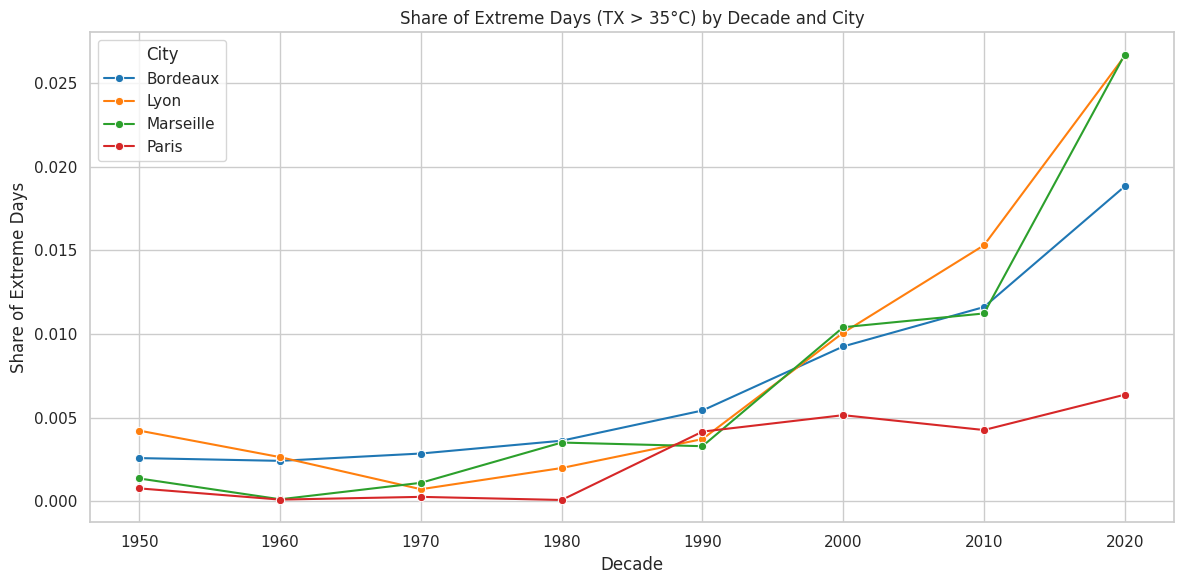

In [12]:
# Data preparation. To Plot extreme heat events per decade

df_station_original["is_extreme_35"] = df_station_original["TX"] > ABS_THRESHOLD

# Basic temporal features
df_station_original["year"] = df_station_original["date"].dt.year

# Simple decade definition, e.g. 1950 -> 1950s, 1967 -> 1960s
df_station_original["decade"] = (df_station_original["year"] // 10) * 10

decadal_stats = (
    df_station_original
    .groupby(["city", "decade"])
    .agg(
        n_days=("TX", "size"),
        n_extreme_35=("is_extreme_35", "sum"),
    )
    .reset_index()
)

display(decadal_stats.head())

decadal_stats["share_extreme_35"] = decadal_stats["n_extreme_35"] / decadal_stats["n_days"]

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=decadal_stats,
    x="decade", y="share_extreme_35", hue="city", marker="o"
)
plt.title("Share of Extreme Days (TX > 35°C) by Decade and City")
plt.xlabel("Decade")
plt.ylabel("Share of Extreme Days")
plt.legend(title="City")
plt.tight_layout()
plt.show()

#### Statistical evaluation

In [13]:
from scipy import stats

city_for_trend = "Marseille"
sub_decade = decadal_stats[decadal_stats["city"] == city_for_trend]

# Use Spearman correlation: decade index vs share_extreme_35
rho_decade, pval_decade = stats.spearmanr(sub_decade["decade"], sub_decade["share_extreme_35"])
rho_decade, pval_decade

(np.float64(0.9047619047619048), np.float64(0.0020082755054294677))

## 6. Decadal Evolution of Extreme Heat Risk

### 6.1. Business Interpretation

The plot of the **share of extreme days (TX > 35°C) by decade and city** reveals:

- In the **1950s–1970s**, the fraction of days with extreme heat is often **very low or close to zero**.
- From the **1980s onward**, the share of extreme days **increases in all cities**, with particularly strong increases in [e.g. Marseille and Lyon].
- The most recent decades (e.g. 2000s, 2010s, 2020s) show a **marked escalation in the frequency of extreme heat days**.

From a policy and planning standpoint:

- Populations in these cities are now **subject to a substantially higher baseline risk of extreme heat** compared to the mid-20th century.
- Urban planning, health services, and energy infrastructure must adapt to **more frequent and intense heat events**.

### 6.2. Statistical Validation

We tested for a **monotonic temporal trend** in the decadal share of extreme days for one city (e.g. Marseille) using **Spearman correlation** between `decade` and `share_extreme_35`:

- **Null hypothesis (H0):** There is **no monotonic association** between decade and the share of extreme days.
- **Alternative hypothesis (H1):** There **is** a monotonic trend (expected to be increasing).

The test output:

- Spearman ρ: 0.9047619047619048  
- p-value: 0.0020082755054294677

p-value is **< 0.05** and ρ is **positive**, we conclude that the **share of extreme days has significantly increased over decades**.

This statistically confirms that **extreme heat frequency has accelerated** in the late 20th and early 21st century.